── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


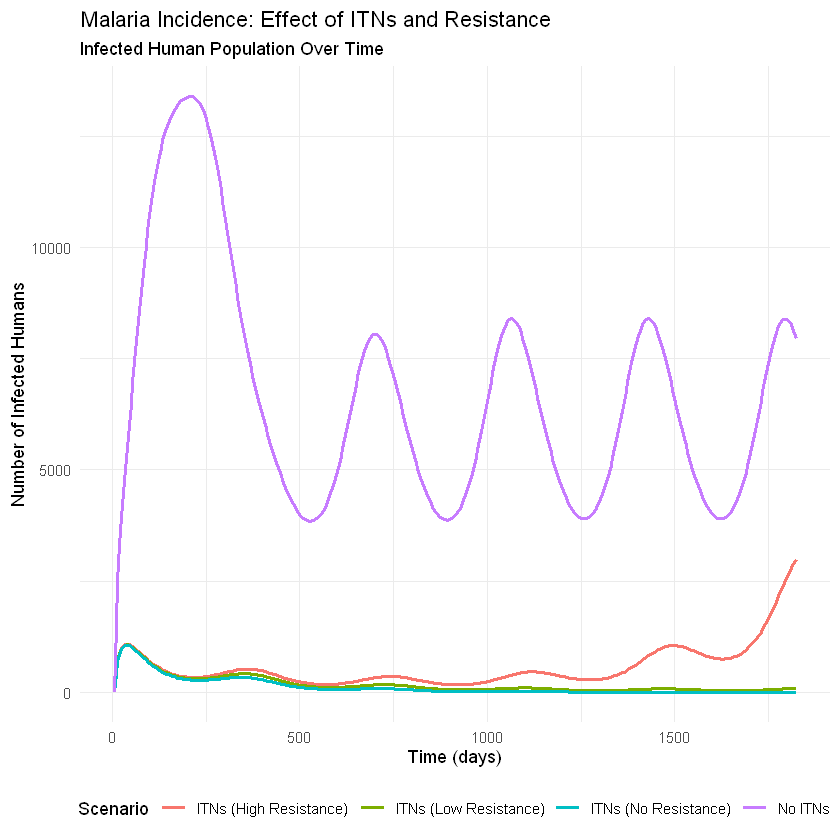

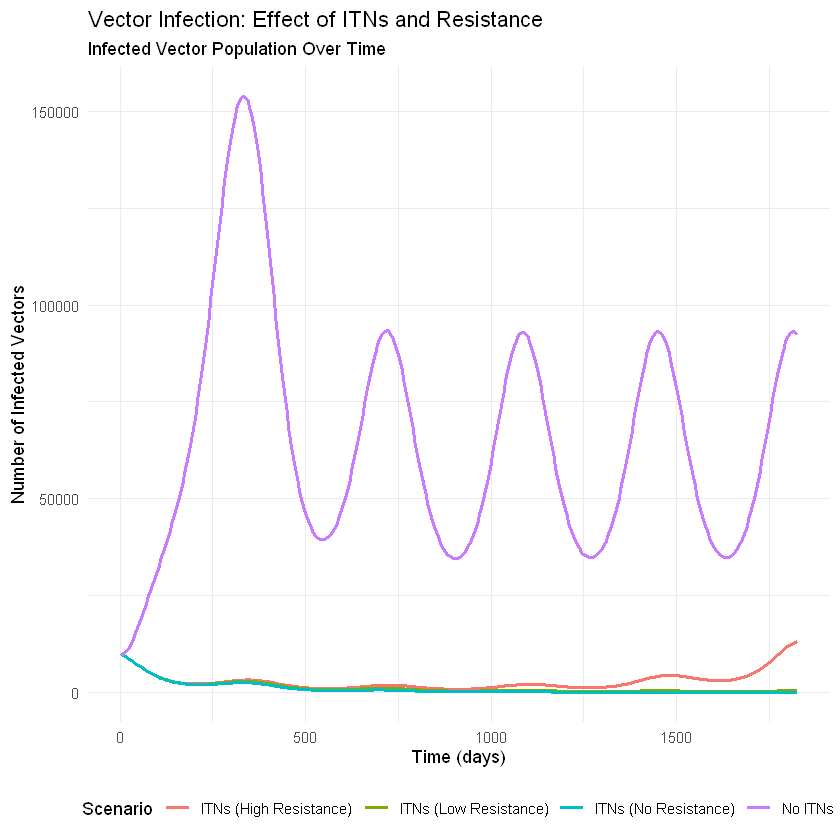


Summary Statistics (all columns):
# A tibble: 4 × 8
  scenario               max_infected_humans mean_infected_humans
  <chr>                                <dbl>                <dbl>
1 ITNs (High Resistance)               2990.                 566.
2 ITNs (Low Resistance)                1070.                 182.
3 ITNs (No Resistance)                 1059.                 128.
4 No ITNs                             13396.                6704.
  total_infected_humans max_infected_vectors mean_infected_vectors
                  <dbl>                <dbl>                 <dbl>
1               206676.               13199.                 2845.
2                66501.               10000                  1196.
3                46776.               10000                   954.
4              2447128.              153855.                65325.
  diff_total_infected_vs_no_itn diff_mean_infected_vs_no_itn
                          <dbl>                        <dbl>
1                     -2240



Table: Summary Statistics of ITN Scenarios

|scenario               | max_infected_humans| mean_infected_humans| total_infected_humans| max_infected_vectors| mean_infected_vectors| diff_total_infected_vs_no_itn| diff_mean_infected_vs_no_itn|
|:----------------------|-------------------:|--------------------:|---------------------:|--------------------:|---------------------:|-----------------------------:|----------------------------:|
|ITNs (High Resistance) |            2990.038|             566.2347|             206675.68|             13198.87|             2844.5262|                      -2240453|                    -6138.227|
|ITNs (Low Resistance)  |            1070.256|             182.1939|              66500.78|             10000.00|             1196.3910|                      -2380628|                    -6522.268|
|ITNs (No Resistance)   |            1059.168|             128.1534|              46776.00|             10000.00|              953.7379|                      -240


ANALYSIS: ITN EFFECTIVENESS WITH RESISTANCE
1. ITN EFFECTIVENESS IN REDUCING MALARIA INCIDENCE:
   - No ITNs: Peak infected humans = 13396 
   - ITNs (No Resistance): Peak = 1059  ( 92.1 % reduction)
   - ITNs (Low Resistance): Peak = 1070  ( 92 % reduction)
   - ITNs (High Resistance): Peak = 2990  ( 77.7 % reduction)

2. RESISTANCE IMPACT:
   - Resistance reduces ITN effectiveness by 14.4 percentage points
   - Even with high resistance, ITNs still provide 77.7 % reduction in peak infections

3. RECOMMENDATION:
   ✓ YES - ITNs should still be used even with resistance

4. ADDITIONAL CONSIDERATIONS:
   - ITN coverage: 80 %
   - Initial ITN efficacy: 90 %
   - Resistance rate: 10 % per year
   - After 5 years, ITN efficacy drops to: 54.6 %


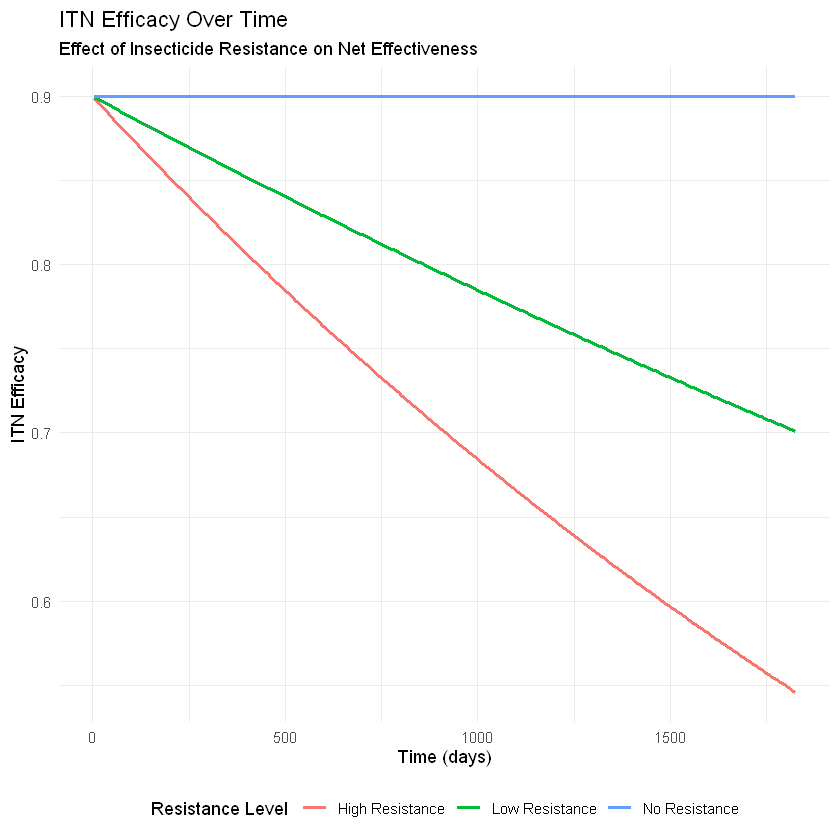

In [ ]:
library(tidyverse)
library(deSolve)

# -------- FUNCTION -------------
# 1. Define the SIR model with ITN effects and resistance
sir_si_itn <- function(t, y, parms) {
  with(as.list(c(y, parms)), {
    Nh  <-  Sh + Ih + Rh
    Nv  <-  Sv + Iv 
    
    # ITN effectiveness decreases over time due to resistance
    current_efficacy <- itn_efficacy * exp(-resistance_rate * t/365)
    
    # Effective ITN coverage (coverage * current efficacy)
    effective_itn_coverage <- itn_coverage * current_efficacy
    
    # Transmission reduction factor due to ITNs
    transmission_reduction <- (1 - effective_itn_coverage)
    
    # Modified transmission rates with ITN effects
    beta_h_to_v <- beta * transmission_reduction
    beta_v_to_h <- beta * transmission_reduction
    
    dSh <-  -beta_v_to_h*Sh*(Nv/Nh)*(Iv/Nv)/4 + (alpha*Rh)
    dIh <-  beta_v_to_h*Sh*(Nv/Nh)*(Iv/Nv)/4 - (gammah*Ih)
    dRh <-  (gammah*Ih) - (alpha*Rh)
    dSv <-  r*Nv*(1-(Nv/K)) - beta_h_to_v*Sv*(Ih/Nh)/4 - (1+sin(t*2*pi/365))/5* d*Sv
    dIv <-  beta_h_to_v*Sv*(Ih/Nh)/4 - (1+sin(t*2*pi/365))/5*d*Iv
    
    return(list(c(dSh, dIh, dRh, dSv, dIv)))
  })
}

# -------------------------
# 2. Define the parameters
# -------------------------
dt <- (1:365)* 5 
R0 <- 2
infectious_period <- 14
gammah <- 1/infectious_period
alpha <- 1/365
beta = betah = betav <- R0 * gammah
K <- 5e5; d <- 1/28; r <- 0.08

# ITN parameters
itn_coverage <- 0.8
itn_efficacy <- 0.9
resistance_rate <- 0.1

params <- c(
  beta = beta,
  gammah = gammah,
  K = K, d = d, r = r,
  alpha = alpha,
  itn_coverage = itn_coverage,
  itn_efficacy = itn_efficacy,
  resistance_rate = resistance_rate
)

# ---------------------------------
# 3. Define the initial conditions
# ---------------------------------
Nh = 200000; Nv = 2*Nh
I0h =  1
I0v = 10000
inits <- c(Sh = Nh - I0h, Ih = I0h, Rh = 0,
           Sv = Nv - I0v, Iv = I0v)

# -------------------------
# 4. Run simulations
# -------------------------
# Scenario 1: No ITNs
params_no_itn <- params
params_no_itn["itn_coverage"] <- 0

results_no_itn <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params_no_itn, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "No ITNs")

# Scenario 2: ITNs with no resistance
params_no_resistance <- params
params_no_resistance["resistance_rate"] <- 0

results_no_resistance <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params_no_resistance, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "ITNs (No Resistance)")

# Scenario 3: ITNs with low resistance
params_low_resistance <- params
params_low_resistance["resistance_rate"] <- 0.05

results_low_resistance <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params_low_resistance, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "ITNs (Low Resistance)")

# Scenario 4: ITNs with high resistance
results_high_resistance <- deSolve::lsoda(
  y = inits, times = dt, func = sir_si_itn,
  parms = params, hmax = 0.1
) |> as.data.frame() |> mutate(scenario = "ITNs (High Resistance)")

# Combine all results
all_results <- bind_rows(
  results_no_itn,
  results_no_resistance,
  results_low_resistance,
  results_high_resistance
)

# -------------------------
# 5. Create plots
# -------------------------
human_infected_plot <- all_results %>%
  ggplot(aes(x = time, y = Ih, color = scenario)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Malaria Incidence: Effect of ITNs and Resistance",
    subtitle = "Infected Human Population Over Time",
    x = "Time (days)", y = "Number of Infected Humans", color = "Scenario"
  ) + theme_minimal() + theme(legend.position = "bottom")

vector_infected_plot <- all_results %>%
  ggplot(aes(x = time, y = Iv, color = scenario)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Vector Infection: Effect of ITNs and Resistance",
    subtitle = "Infected Vector Population Over Time",
    x = "Time (days)", y = "Number of Infected Vectors", color = "Scenario"
  ) + theme_minimal() + theme(legend.position = "bottom")

efficacy_data <- data.frame(
  time = dt,
  efficacy_no_resistance = params_no_resistance["itn_efficacy"] * exp(-params_no_resistance["resistance_rate"] * dt/365),
  efficacy_low_resistance = params_low_resistance["itn_efficacy"] * exp(-params_low_resistance["resistance_rate"] * dt/365),
  efficacy_high_resistance = params["itn_efficacy"] * exp(-params["resistance_rate"] * dt/365)
) %>%
  pivot_longer(cols = -time, names_to = "resistance_type", values_to = "efficacy") %>%
  mutate(resistance_type = case_when(
    resistance_type == "efficacy_no_resistance" ~ "No Resistance",
    resistance_type == "efficacy_low_resistance" ~ "Low Resistance",
    resistance_type == "efficacy_high_resistance" ~ "High Resistance"
  ))

efficacy_plot <- efficacy_data %>%
  ggplot(aes(x = time, y = efficacy, color = resistance_type)) +
  geom_line(linewidth = 1) +
  labs(
    title = "ITN Efficacy Over Time",
    subtitle = "Effect of Insecticide Resistance on Net Effectiveness",
    x = "Time (days)", y = "ITN Efficacy", color = "Resistance Level"
  ) + theme_minimal() + theme(legend.position = "bottom")

print(human_infected_plot)
print(vector_infected_plot)
print(efficacy_plot)

# -------------------------
# 6. Summary statistics
# -------------------------
summary_stats <- all_results %>%
  group_by(scenario) %>%
  summarise(
    max_infected_humans = max(Ih),
    mean_infected_humans = mean(Ih),
    total_infected_humans = sum(Ih),
    max_infected_vectors = max(Iv),
    mean_infected_vectors = mean(Iv),
    .groups = "drop"
  )

# Baseline comparison
baseline_total_infected <- summary_stats$total_infected_humans[summary_stats$scenario == "No ITNs"]
baseline_mean_infected <- summary_stats$mean_infected_humans[summary_stats$scenario == "No ITNs"]
summary_stats <- summary_stats %>%
  mutate(
    diff_total_infected_vs_no_itn = total_infected_humans - baseline_total_infected,
    diff_mean_infected_vs_no_itn = mean_infected_humans - baseline_mean_infected
  )

# ✅ Display all columns in full
cat("\nSummary Statistics (all columns):\n")
print(summary_stats, width = Inf)
glimpse(summary_stats)

if (requireNamespace("knitr", quietly = TRUE)) {
  cat("\nFormatted Table:\n")
  knitr::kable(summary_stats,
               caption = "Summary Statistics of ITN Scenarios",
               format = "pipe")
}

# -------------------------
# 7. Analysis and conclusions
# -------------------------
cat("\n", paste(rep("=", 60), collapse=""), "\n")
cat("ANALYSIS: ITN EFFECTIVENESS WITH RESISTANCE\n")
cat(paste(rep("=", 60), collapse=""), "\n")

# Peak values
no_itn_max <- summary_stats$max_infected_humans[summary_stats$scenario == "No ITNs"]
itn_no_resistance_max <- summary_stats$max_infected_humans[summary_stats$scenario == "ITNs (No Resistance)"]
itn_low_resistance_max <- summary_stats$max_infected_humans[summary_stats$scenario == "ITNs (Low Resistance)"]
itn_high_resistance_max <- summary_stats$max_infected_humans[summary_stats$scenario == "ITNs (High Resistance)"]

# Reduction %
reduction_no_resistance <- (no_itn_max - itn_no_resistance_max) / no_itn_max * 100
reduction_low_resistance <- (no_itn_max - itn_low_resistance_max) / no_itn_max * 100
reduction_high_resistance <- (no_itn_max - itn_high_resistance_max) / no_itn_max * 100

cat("1. ITN EFFECTIVENESS IN REDUCING MALARIA INCIDENCE:\n")
cat("   - No ITNs: Peak infected humans =", round(no_itn_max, 0), "\n")
cat("   - ITNs (No Resistance): Peak =", round(itn_no_resistance_max, 0),
    " (", round(reduction_no_resistance, 1), "% reduction)\n")
cat("   - ITNs (Low Resistance): Peak =", round(itn_low_resistance_max, 0),
    " (", round(reduction_low_resistance, 1), "% reduction)\n")
cat("   - ITNs (High Resistance): Peak =", round(itn_high_resistance_max, 0),
    " (", round(reduction_high_resistance, 1), "% reduction)\n\n")

cat("2. RESISTANCE IMPACT:\n")
cat("   - Resistance reduces ITN effectiveness by", round(reduction_no_resistance - reduction_high_resistance, 1), "percentage points\n")
cat("   - Even with high resistance, ITNs still provide", round(reduction_high_resistance, 1), "% reduction in peak infections\n\n")

cat("3. RECOMMENDATION:\n")
if (reduction_high_resistance > 20) {
  cat("   ✓ YES - ITNs should still be used even with resistance\n")
} else if (reduction_high_resistance > 10) {
  cat("   ⚠ MODERATE - ITNs provide some benefit but limited effectiveness\n")
} else {
  cat("   ✗ NO - ITNs may not be cost-effective with high resistance\n")
}

cat("\n4. ADDITIONAL CONSIDERATIONS:\n")
cat("   - ITN coverage:", round(itn_coverage * 100, 0), "%\n")
cat("   - Initial ITN efficacy:", round(itn_efficacy * 100, 0), "%\n")
cat("   - Resistance rate:", round(resistance_rate * 100, 1), "% per year\n")
cat("   - After 5 years, ITN efficacy drops to:", round(itn_efficacy * exp(-resistance_rate * 5) * 100, 1), "%\n")




Table: Summary Statistics of ITN Scenarios

|scenario               | max_infected_humans| mean_infected_humans| total_infected_humans| max_infected_vectors| mean_infected_vectors| diff_total_infected_vs_no_itn| diff_mean_infected_vs_no_itn|
|:----------------------|-------------------:|--------------------:|---------------------:|--------------------:|---------------------:|-----------------------------:|----------------------------:|
|ITNs (High Resistance) |            2990.038|             566.2347|             206675.68|             13198.87|             2844.5262|                      -2240453|                    -6138.227|
|ITNs (Low Resistance)  |            1070.256|             182.1939|              66500.78|             10000.00|             1196.3910|                      -2380628|                    -6522.268|
|ITNs (No Resistance)   |            1059.168|             128.1534|              46776.00|             10000.00|              953.7379|                      -2400352|                    -6576.308|
|No ITNs                |           13395.736|            6704.4616|            2447128.47|            153854.83|            65324.7800|                             0|                        0.000|